In [1]:
import numpy as np

import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotting as pt

In [2]:
def simulate_bites(y,eir):
    '''
    Produces a vector with bite times up until year, y, is reached.

    Time between bites pulled from exponential distribution wih mean rate of k = eir/365.
    '''
    k = eir/365
    n = round(y*eir*2)
    spaces = st.expon.rvs(scale=(1/k), loc=0, size=n)
    times = np.cumsum(spaces)
    trimmed = times[times <= y*365]
    bites = np.ceil(trimmed).astype(int)
    return bites

def simulate_genotypes(n,a):
    '''
    n = number of strains to simulate
    a = vector whose length corresponds to number of loci.
    Each entry corresponds to the number of alleles at that loci.
    so a = [3,4,6] will simulate a strain with 3 loci. The first
    loci has 3 alleles; the second loci has 4 alleles, and the third
    loci has 6 alleles.

    Returns genotype as a L x n matrix, where L = the number of loci.
    '''
    length = len(a)
    M = np.empty((length,n),dtype=int)
    for i in range(n):
        floats = np.random.rand(length) # Currently only simulates things from uniform distribution
        genotype = np.ceil(floats*a)-1 # Current only simulates things ffrom uniform distribution
        M[:,i] = genotype
    return M

def get_mz(meroz=0.8,mshape=1): ### Work here
    '''
    Generates starting number of merozoites from a lognormal distribution.
    Values from here: https://www.science.org/doi/10.1126/scitranslmed.aag2490
    '''
    mz = st.lognorm.rvs(s=mshape,scale=meroz)
    return mz

def get_r(growthrate=0.6,rscale=0.1):
    '''
    Generates r from normal distribution.
    Values from here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7198127/
    '''
    r = st.norm.rvs(loc = growthrate, scale=rscale)
    return r

def simulate_params(n,meroz,growthrate,mshape,rscale):
    '''
    Simulates mz and growth rate for strains.
    Returns 2 x n matrix.

    Inputs:
        n = number of strains
        meroz = average starting number of merozites
        growthrate = average starting growthrate
    '''
    M = np.zeros((2,n))
    for i in np.arange(n):
        M[0,i] = get_mz(meroz,mshape)
        M[1,i] = get_r(growthrate,rscale)
    return M

def create_allele_matrix(a,y):
    '''
    Creates matrix to track parasitemia.
    '''
    length = len(a)
    width = max(a)
    days = 365*y
    M = np.zeros((length,width,days))
    return M

def create_strain_matrix(n,y):
    '''
    Creates n x y*365 matrix to track strains presence per day.
    '''
    M = np.zeros((n,y*365))
    return M

def add_infection(t,j,mz,gtype,sM,pM):
    '''
    Adds infection to strain & parasite matrices.

    Inputs:
        t = time in days
        j = bite number
        mz = start of merozites
        gtype = genotype of infection
        sM = matrix tracking parasitemia by strain
        pM = matrix tracking parasitemia by allele
    '''
    sM[j,t] = mz
    for locus, allele in enumerate(gtype): # Might be able to speed up with vectorization here
        pM[locus, allele,t] = mz

def update_immunity(t,locus,allele,pM,iM,tHalf): # Use with np.vectorize()
    '''
    Immunity exponentially decays if parasite not present.

    Inputs:
        t = time in days
        locus = locus number
        allele = allele number
        pM = matrix tracking parasitemia by allele
        iM = matarix tracking immunity by allele
        tHalf = half-life of immunity
    '''
    gamma = 0.693/tHalf
    if t >= 14:
        if pM[locus,allele,t-14] > 0:
            iM[locus,allele,t] = 1
        elif iM[locus,allele,t-1] != 0:
            iM[locus,allele,t] = iM[locus,allele,t-1]*np.exp(-gamma)

def get_strain_immunity(gtype,i2,w):
    '''
    Returns immunity to strain.
    gtype = genotype of strain
    i2 = immune matrix at t of interest.
    w = vector weighting immunity by allele
    '''
    n_loci = len(gtype)
    cross = np.empty(n_loci)
    for i in np.arange(n_loci): ## Could try to vectorize; might speed up.
        allele = gtype[i]
        cross[i] = i2[i,allele]
    imm = (cross*np.asarray(w)).sum()
    return imm

def modulate_growth_rate(imm,r0,rend=-0.05,xh=0.3, b=-2):
    '''
    Modulates growth rate based on immunity.
    rend = final growth rate at full immunity
    xh = inflection point for % immunity change
    b = intensity of immune effect
    '''
    if imm == 0:
        return r0
    else:
        c = np.tan(np.pi/2*xh)**b
        r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend
    return r

def update_parasitemia(t,j,w,gM,iM,rV,sM,pM,k = 5*10**5,rend=-0.05,xh=0.3,b=-2,pgone=0.001): # vectorize across J
    '''
    Updates parasitemia for each strain and allele by bite number.

    Inputs:
        t = time in days
        j = bite number
        w = vector weighting immunity by allele
        gM = genotype matrix
        iM = immune matrix
        rV = vector tracking initial growth rate by bite number.
        sM = matrix tracking parasitemia by strain
        pM = matrix tracking parasitemia by allele
        k = carrying capacity
        rend = growth rate with 100% immunity
        xh = param scaling immunity's impact on growth rate
        b = param scaling immunity's impact on growth rate
        pgone = threshold below which infection goes to zero
    '''
    done = set()
    imm = get_strain_immunity(gM[:,j],iM[:,:,t-1],w)
    r = modulate_growth_rate(imm,rV[j],rend,xh,b)

    if sM[j,t] == 0:
        p0 = sM[j,t-1]
        if p0 != 0:
            if r > 0:
                p = k/(1+((k-p0)/p0)*np.exp(-r))
            else:
                p = p0*np.exp(r)
                if p < pgone:
                    p = 0
                    done.add(j)
        else:
            p = 0

        sM[j,t] = p

        for loci, allele in enumerate(gM[:,j]): # Might be able to speed up with vectorization here
            pM[loci, allele,t] += p
    return done

def get_fever_threshold(arr,t):
    '''
    Returns fever threshold at t
    '''
    thresh = arr[arr[:,0]>=(t/365),1][0]
    return thresh

def treat_malaria(t, threshhold, pM, sM, m,a):
    '''
    Treat if parasitemia goes above certain threshold. Modifies parasite density
    matrix & strain matrix. Returns updated list with days malaria has occured.
        threshold = threshold for treatment
        pM = matrix tracking parasite density by allele across time.
        sM = matrix tracking parasitemia by strain across time.
        m = list with days malaria has occured
    '''
    if pM[0,:,t-1].sum(axis=0) > threshhold:
        pM[:,:,t] = 0
        sM[:,t] = 0
        m.append(t)
        a = set()
    return m,a

def load_data():
    '''
    Loads data used in the model
    '''
    fever = np.load("../data/fever.npy")
    breaks = np.load("../data/breaks.npy")
    return fever, breaks

def get_fever_arr(eir,fever,breaks):
    '''
    Returns 40 x 2 array, where column 0 is age cutoffs, and column 1 is parasite density
    for fever threshold at that age.
    '''
    eir_loc = (breaks[:,2]>=eir).nonzero()[0][0]
    age_index,pardens_index = (fever[:,:,eir_loc]).nonzero()
    age_breaks, age_loc = np.unique(age_index,return_index=True)
    pdens = breaks[pardens_index[age_loc],1]
    age = breaks[age_breaks,0]
    arr = np.stack((age,10**pdens),axis=1)
    return arr

def simulate_person(y,eir,a,w,meroz=0.8,growthrate=1.2,mshape=1,rscale=0.1,tHalf=100,rend=-0.05,xh=0.3,b=-2,k=5*10**5,pgone=0.001):
    '''
    Runs simulation for one person. Returns matrix tracking parasitemia by allele,
    matrix tracking immunity by allele, matrix tracking parasitemia by strain, and
    a list containing the days of every malaria episode someone had.

    Inputs:
        y = years to simulate
        eir = entomological inoculation rate
        a = vector with number of allels per loci
        meroz = average starting number of merozites
        growthrate = average starting growthrate
        w = vector weighting immunity by allele
        k = carrying capacity
        rend = growth rate at 100% immmunity
        xh = param scaling immunity's impact on growth rate
        b = param scaling immunity's impact on growth rate
        pgone = threshold below which infection goes to zero
    '''
    # Simulates bites & strain characteristics
    bites = simulate_bites(y,eir)
    n = len(bites)
    gtypes = simulate_genotypes(n,a)
    params = simulate_params(n,meroz,growthrate,mshape=mshape,rscale=rscale)

    # Creates objects to record
    pM = create_allele_matrix(a,y)
    iM = create_allele_matrix(a,y)
    sM = create_strain_matrix(n,y)
    malaria = []
    active = set()

    # Runs forward time simulation
    ## Day 0:
    t = 0
    if t in bites: # Case where first bite is on day zero.
        locs = np.where(bites == t)
        for j in locs[0]:
            add_infection(t,j,params[0,j],gtypes[:,j],sM,pM)
            active.add(j)

    ## Day 1+
    for t in np.arange(1,y*365):
        if t in bites:
            if not len(malaria) > 0 or t - malaria[-1] > 14:
                locs = np.where(bites == t)
                for j in locs[0]:
                    add_infection(t,j,params[0,j],gtypes[:,j],sM,pM)
                    active.add(j)
        if active:
            for j in active:
                drop = update_parasitemia(t=t,j=j,w=w,gM=gtypes,iM=iM,rV=params[1,:],sM=sM,pM=pM,k=k,rend=rend,xh=xh,b=b,pgone=pgone)
                if drop:
                    active = active.difference(drop)
        thresh = get_fever_threshold(fever_arr, t)
        malaria,active = treat_malaria(t,thresh,pM,sM,malaria,active)
        for locus in np.arange(len(a)):
            for allele in np.arange(max(a)):
                update_immunity(t=t,locus=locus,allele=allele,pM=pM,iM=iM,tHalf=tHalf)
    return pM, iM, sM, malaria

def simulate_cohort(n_people,y,eir,a,w,meroz=0.8,growthrate=1.2,mshape=1,rscale=0.1,tHalf=100,rend=-0.05,xh=0.3,b=-2,k=5*10**5,pgone=0.001):
    '''
    Simulates an entire cohort of individuals.

    Returns n_people x loci x alleles x t matrices tracking parasite density & immunity at each allele.
    Returns dictionary containing strain matrices for each person.
    Returns dictionary containing lists of malaria episodes for each person.
    Returns dictionary containing infection matrices for each person.

    Input:
        y = years to simulate
        a = vector of len(loci) specifying number of alleles at each locus
        w = immune weighting for each locus
        delta = immunity waning rate
    '''
    # Create objects to record
    all_parasites = np.zeros((n_people, len(a), max(a), y*365))
    all_immunity = np.zeros((n_people, len(a), max(a), y*365))
    all_strains = {}
    all_malaria = {}

    # Load dataset for fever threshhold
    fever, breaks = load_data()
    fever_arr = get_fever_arr(eir,fever,breaks)

    # Simulate people
    for person in range(n_people):
        pmatrix, imatrix, smatrix, malaria = simulate_person(y,eir,a,w,meroz=meroz,growthrate=growthrate,mshape=mshape,rscale=rscale,tHalf=tHalf,rend=rend,xh=xh,b=b,k=k,pgone=pgone)
        all_parasites[person,:,:,:] = pmatrix
        all_immunity[person,:,:,:] = imatrix
        all_strains[person] = smatrix
        all_malaria[person] = malaria

    return all_parasites, all_immunity, all_strains, all_malaria

In [3]:
y = 8
eir = 10
a = [5,5,5,5,5,5]
w = [0,1/2,1/10,1/10,1/10,1/5]
fever,breaks = load_data()
fever_arr = get_fever_arr(eir,fever,breaks)
n_people=100

In [4]:
pmatrix, imatrix, smatrix, malaria = simulate_person(y,eir,a,w)

IndexError: index 5 is out of bounds for axis 1 with size 5

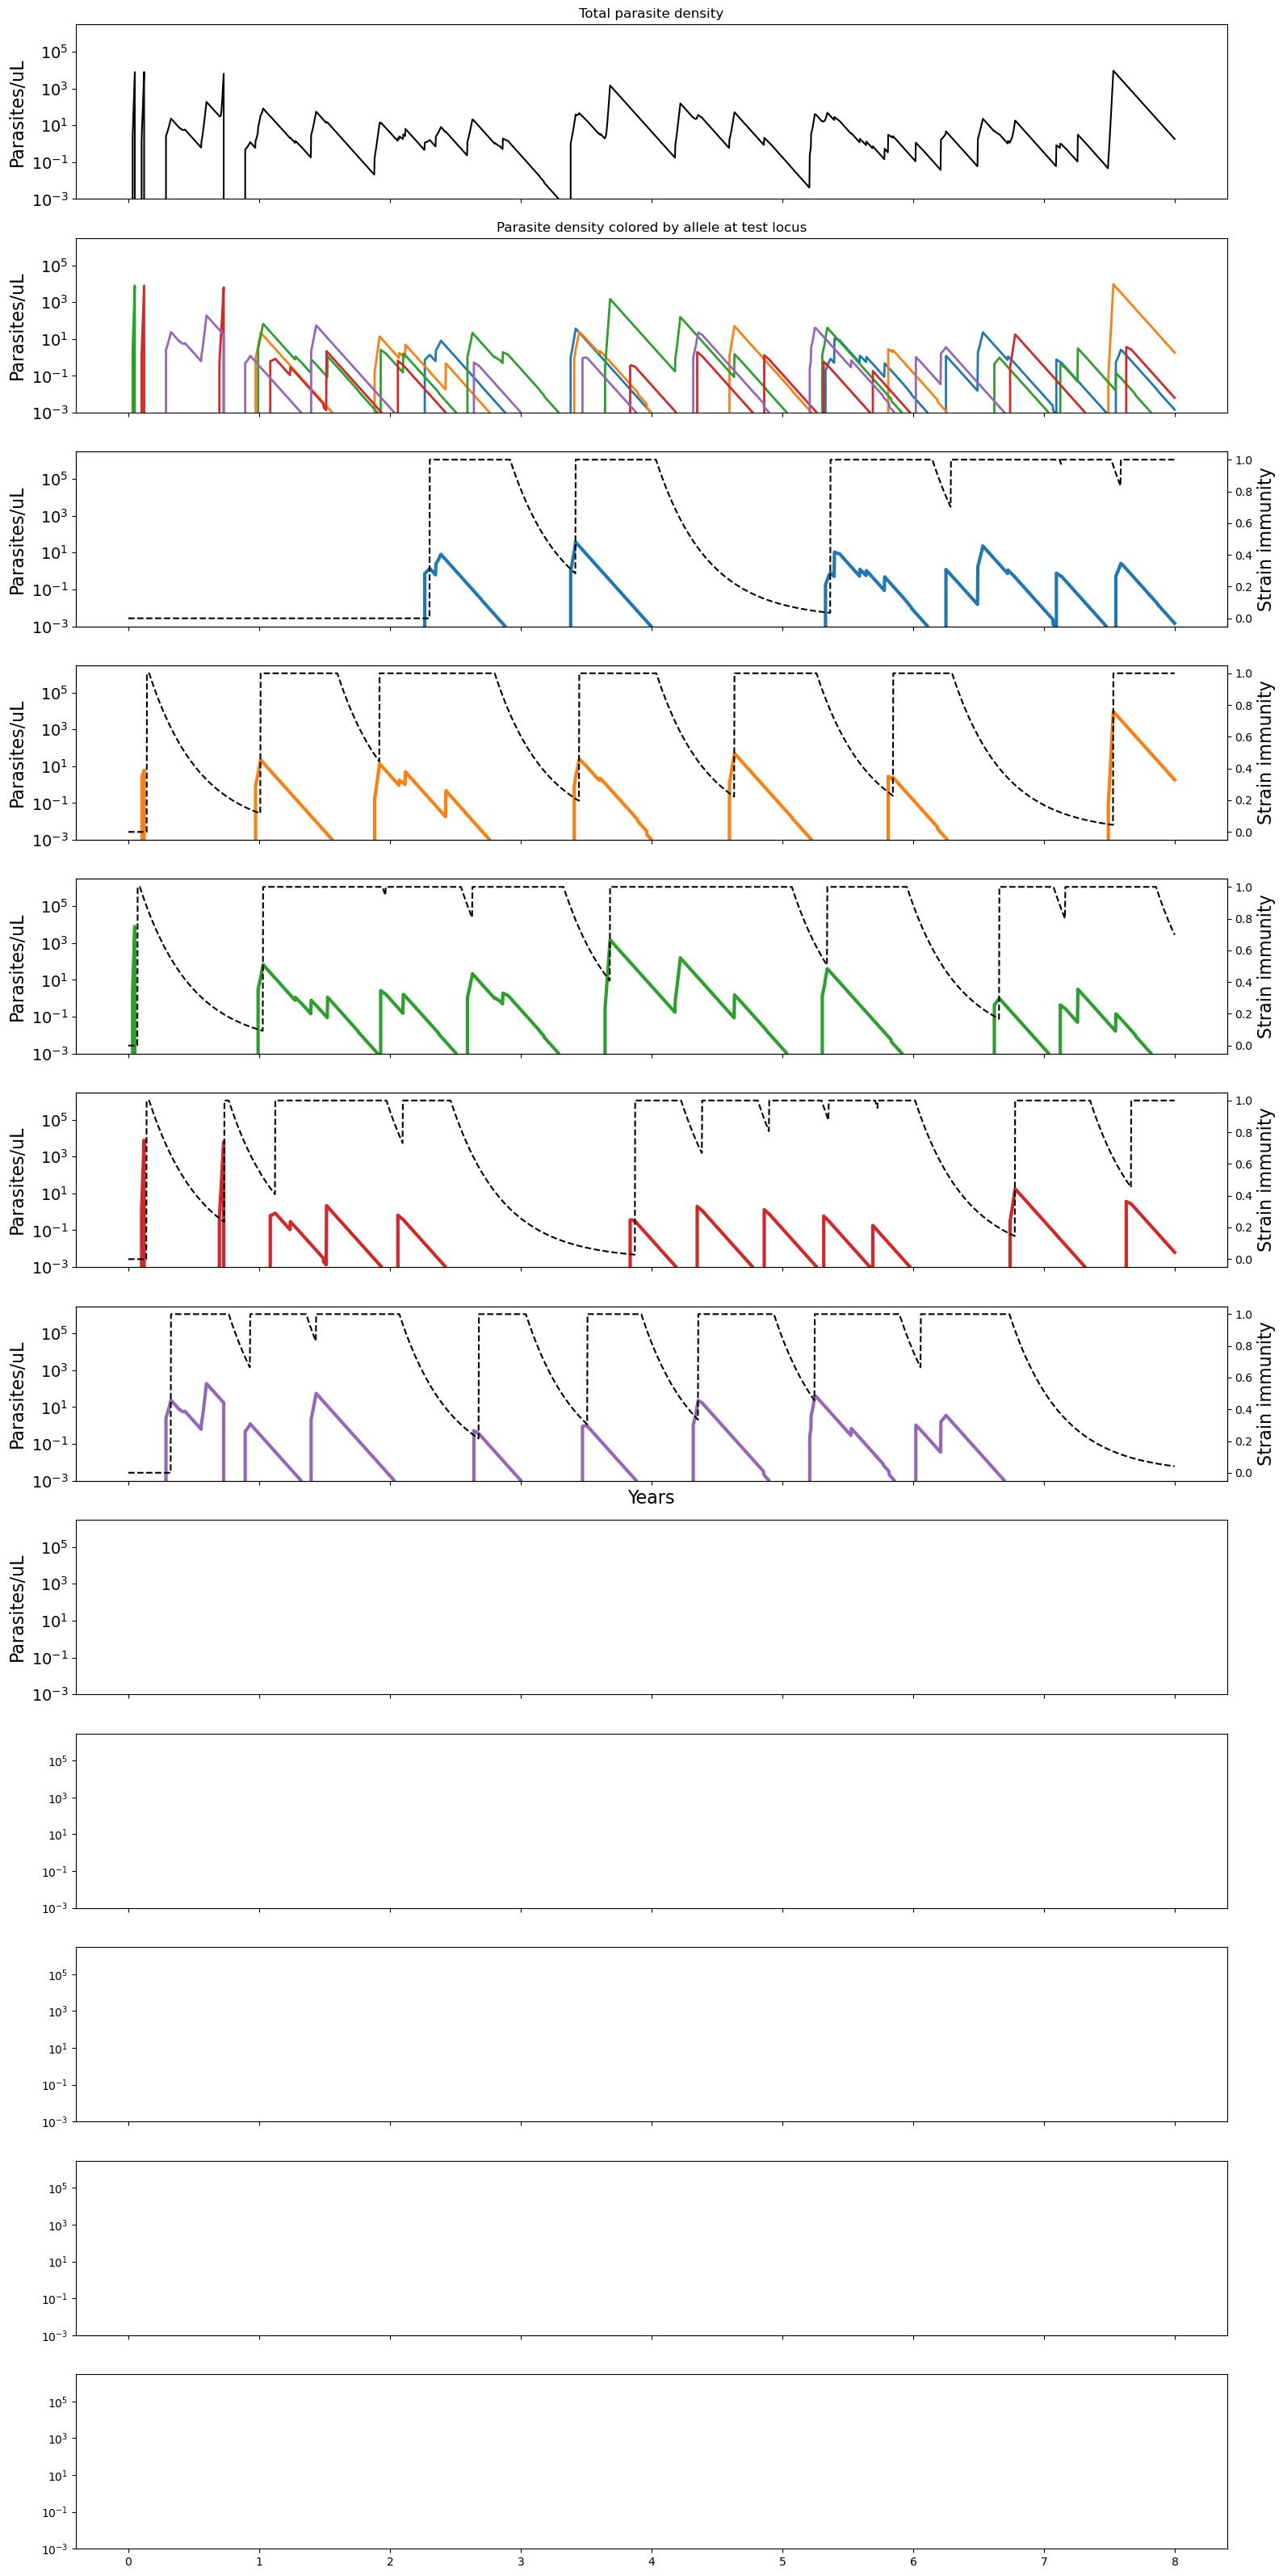

In [5]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

fig, ax = plt.subplots(nrows=12, sharey=True, sharex=True, tight_layout=True, figsize=(16,32))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')
ax[0].plot(np.arange(y*365)/365, pmatrix[-1,:,:].sum(axis=0),color="black")
for strain in np.arange(a[-1]):
    iStrain = pmatrix[-1,strain,:]
    if np.sum(iStrain) > 1:
        ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
ax[0].set_ylim(0.001,3000000)
ax[6].set_xlabel('Years',fontsize=16)
ax[0].set_ylabel('Parasites/uL',fontsize=16)
ax[0].set_title('Total parasite density')
ax[1].set_title('Parasite density colored by allele at test locus')
ax[1].set_ylabel('Parasites/uL',fontsize=16)
for row in range(2,12):
    ax[row].tick_params(axis='both', which='major', labelsize=14)
    ax[row].set_ylabel('Parasites/uL',fontsize=16)
    other = [strain for strain in range(0,5) if strain != row-2]
    ax[row].plot(np.arange(y*365)/365, pmatrix[-1,row-2,:],linewidth=3,color=colors[row-2])

    #for strain in other:
     #   ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,strain,:],linewidth=2,alpha=0.2,color=colors[strain])

    ax2 = ax[row].twinx()
    ax2.set_ylabel('Strain immunity',fontsize=16)
    ax2.plot(np.arange(y*365)/365, imatrix[-1,row-2,:],linewidth=1.5,color='black',linestyle='dashed')

In [6]:
all_parasites, all_immunity, all_strains, all_malaria = simulate_cohort(n_people,y,eir,a,w)

Parasite density
min:-2.9940950932729775
max:4.245530743904862
median:0.5768359333337382
mean:0.6926221776138308
std:1.2284930187600724
---------------------
Infection length
min:1
max:363
median:141.0
mean:138.3332044341325
std:67.36471329552448
---------------------
MOI
min:0
max:12
median:2.0
mean:2.651891891891892
std:2.5319385136612786
---------------------
% Parasitemia
min:0.24324324324324326
max:0.972972972972973
median:0.7567567567567568
mean:0.7108108108108108
std:0.15204954788146166
---------------------
Malaria cases per year
min:0.25
max:2.0
median:0.625
mean:0.74
std:0.3315116890850155
---------------------


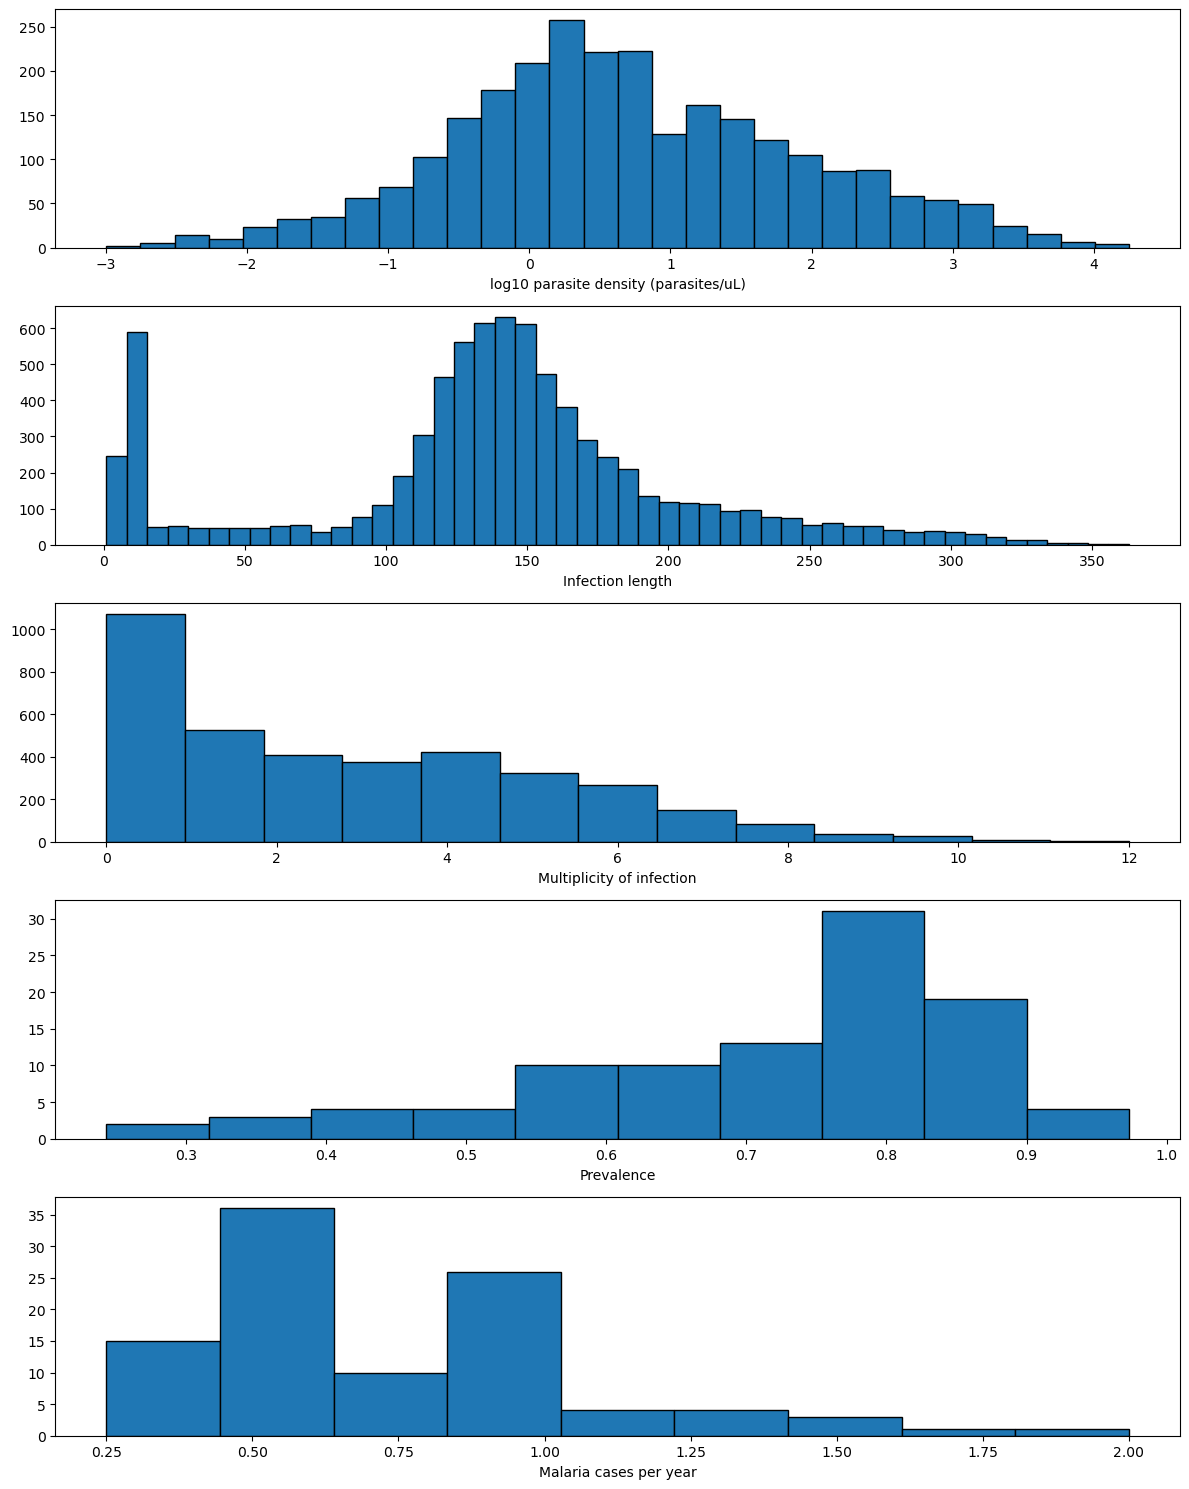

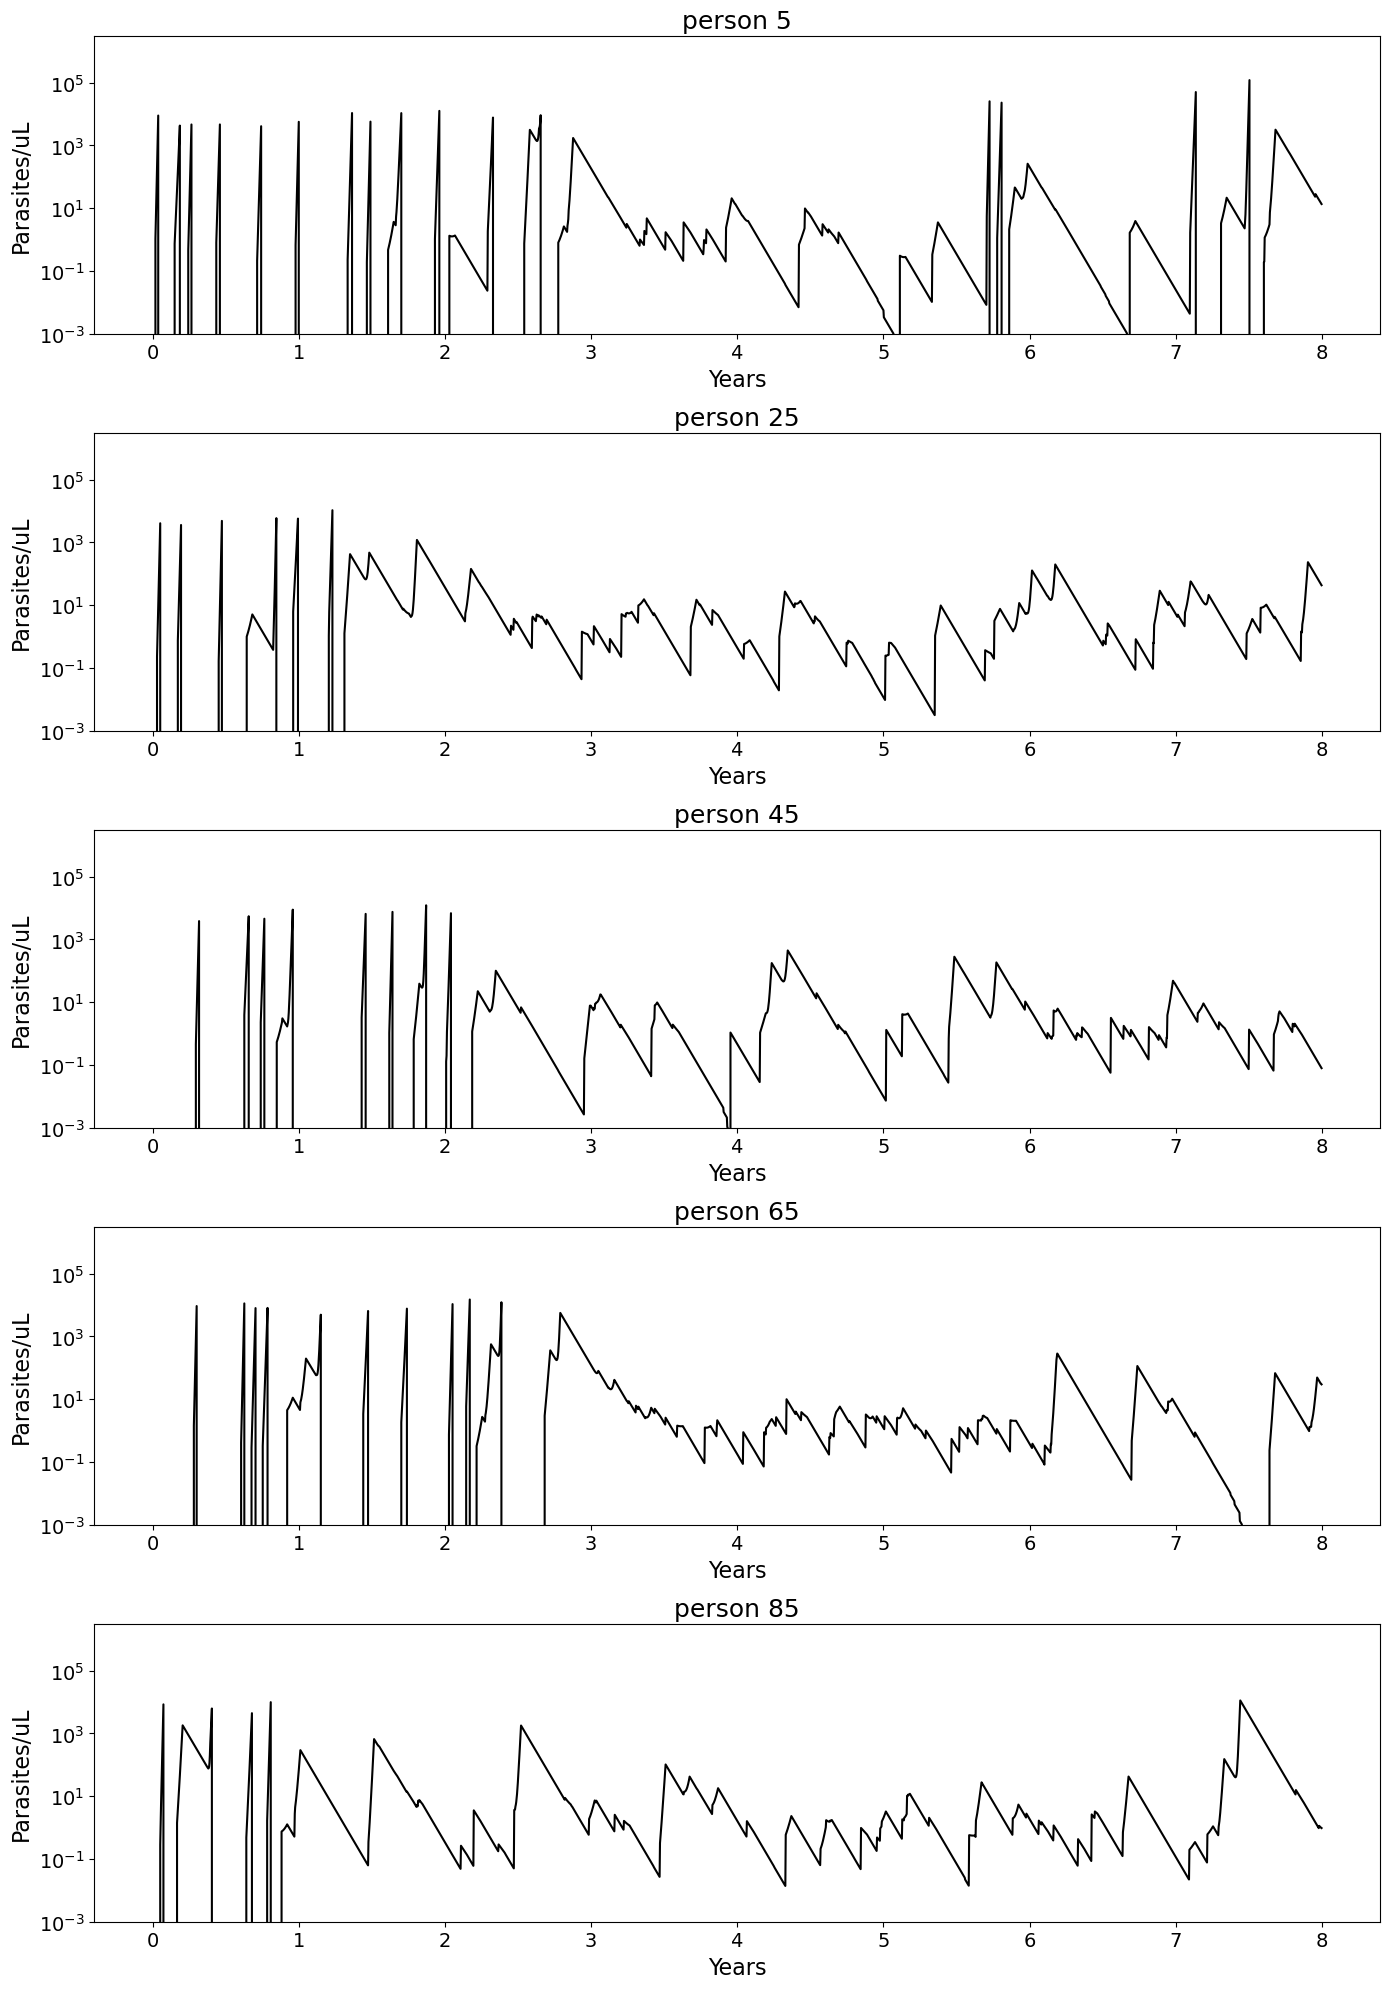

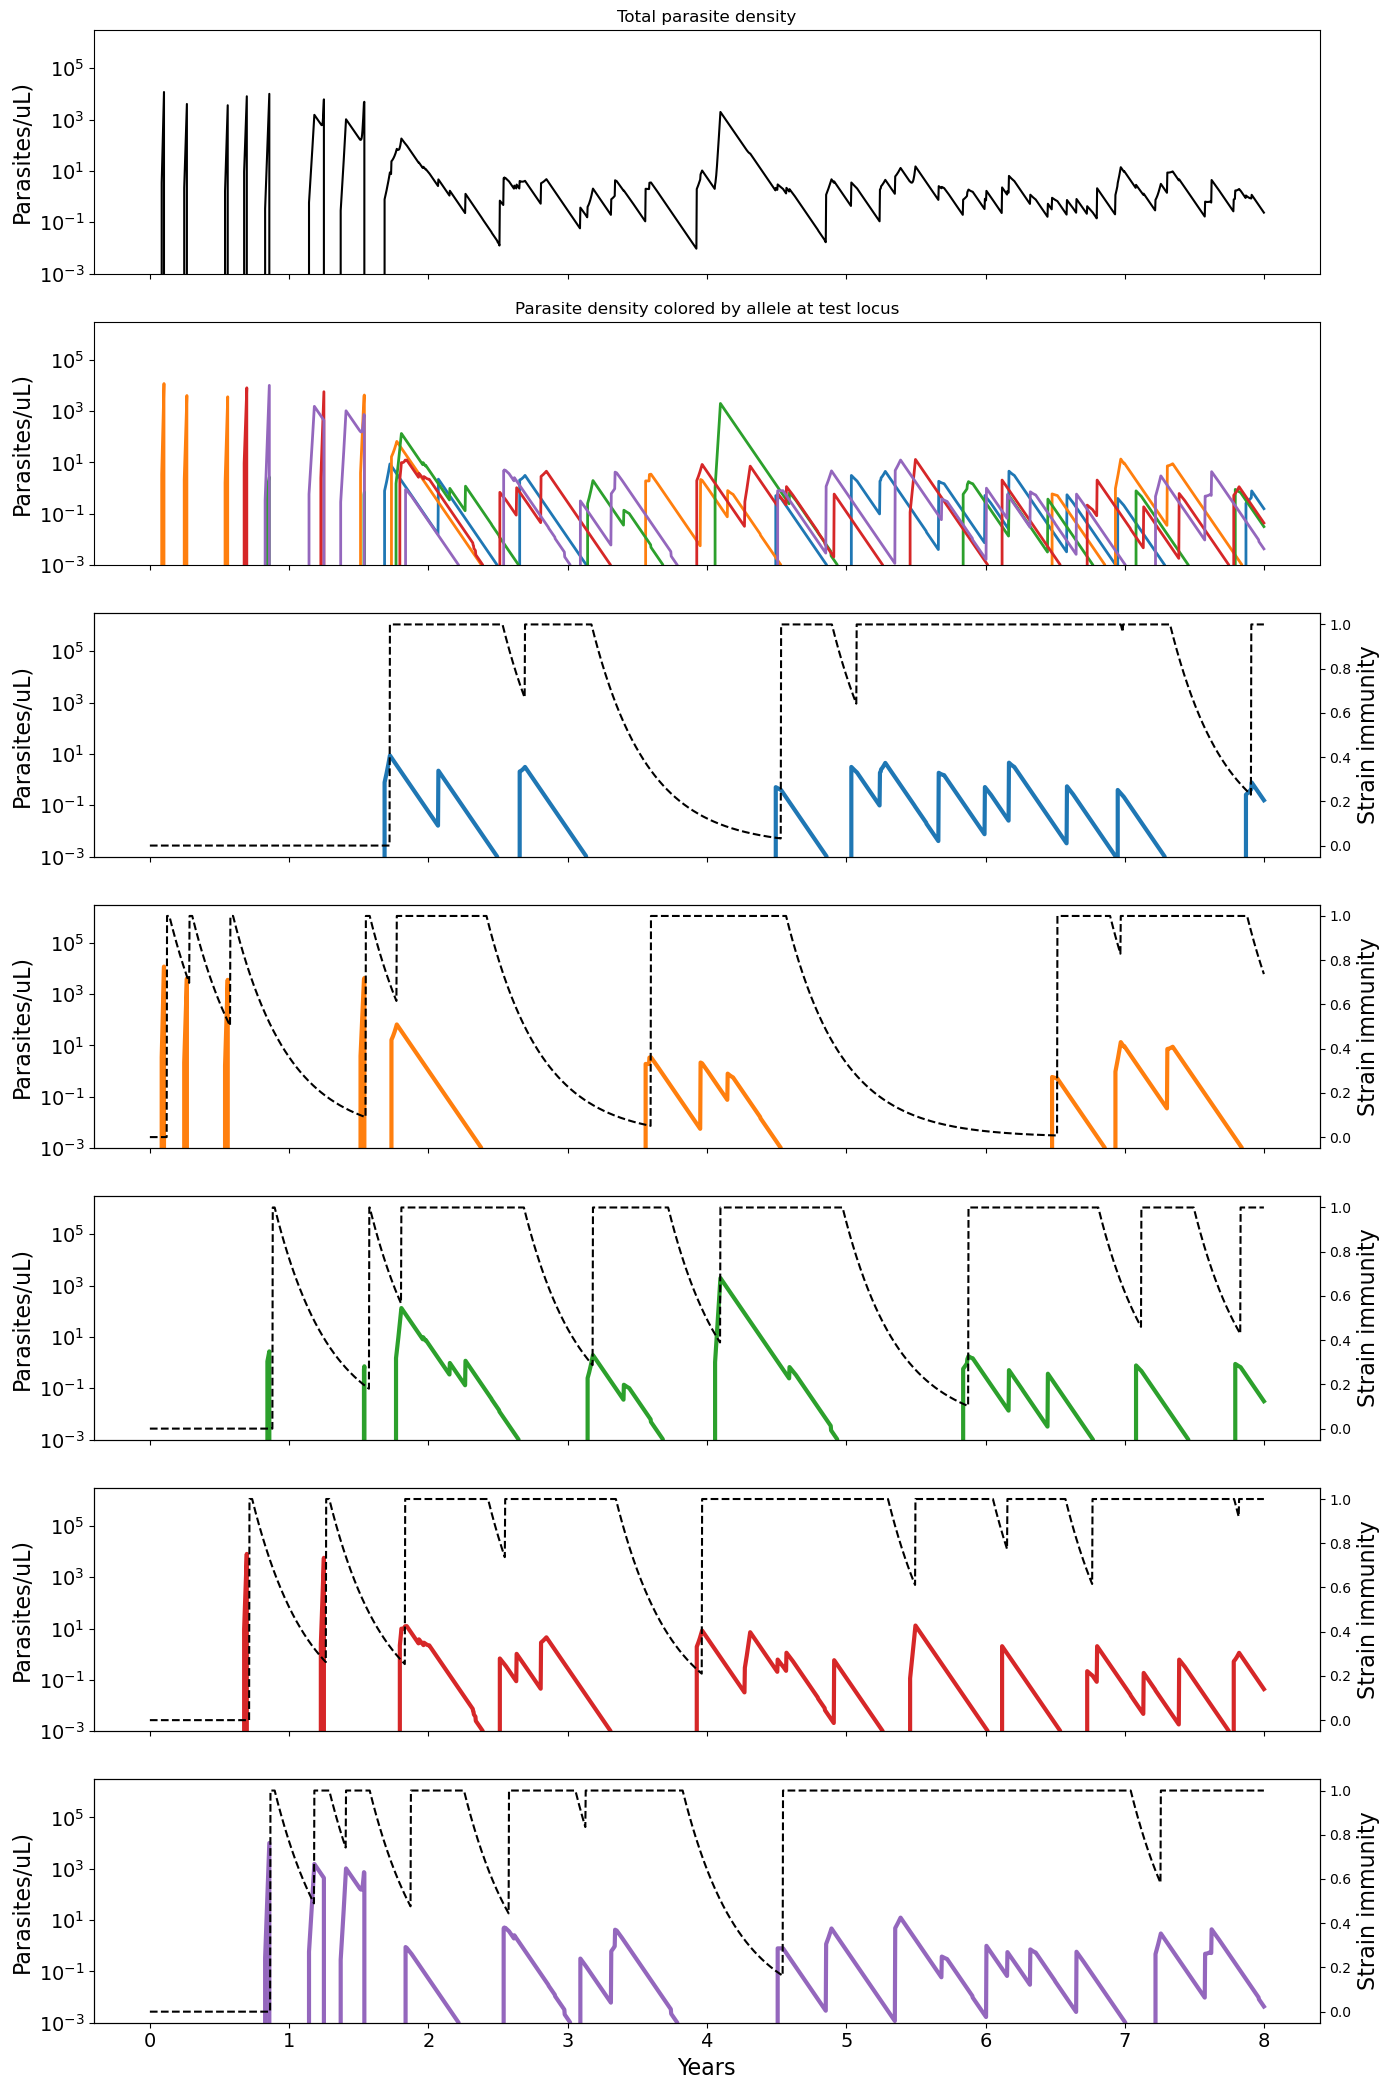

In [8]:
pt.check_outcomes(a,5,all_parasites,all_immunity,all_strains,all_malaria)

In [37]:
def get_peaks(pdensity):
    '''
    Finds the time of all parasite density peaks
    '''
    lag = np.pad(pdensity,1,mode='constant')[:-2]
    sign = np.sign(pdensity-lag).astype(int)
    lead = np.pad(sign,(0,1), mode='constant')[1:]
    peak = np.where(sign > lead)[0]
    return peak

In [44]:
pdensity = pmatrix[0,:,:].sum(axis=0)

get_peaks(pdensity)


array([  26,   54,  100,  154,  351,  414,  543,  575,  656,  801,  806,
        813,  834,  911, 1008, 1033, 1075, 1090, 1180, 1270, 1275, 1289,
       1346, 1420, 1482, 1484, 1511, 1525, 1571, 1584, 1686, 1754, 1766,
       1784, 1849, 1857, 1930, 1976, 1990, 1996, 2042, 2073, 2151, 2239,
       2270, 2289, 2314, 2324, 2378, 2480, 2510, 2551, 2564, 2592, 2647,
       2656, 2661, 2691, 2695, 2748, 2776, 2889])

In [45]:
np.where(smatrix>0)[1]

array([  17,   18,   19, ..., 2917, 2918, 2919])

3.1225817435259557


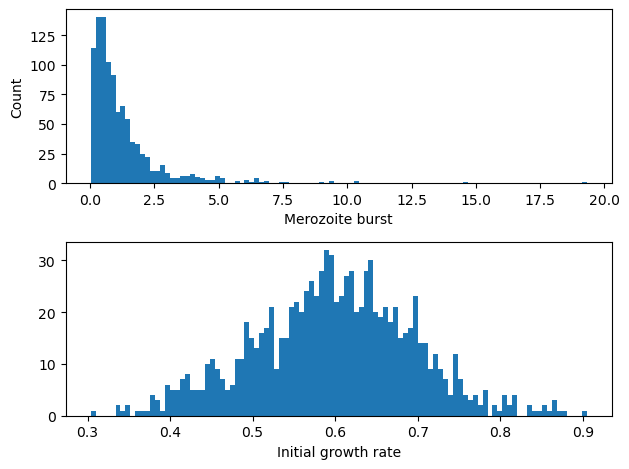

In [48]:
# params = np.zeros((2,1000))

for i in np.arange(1000):
    params[0,i] = get_mz(0.8,shape=1,loc=0)
    params[1,i] = get_r(0.6,scale=0.1)
    
fig,ax = plt.subplots(nrows=2, tight_layout = True)
ax[0].hist(params[0,:],bins=100)
#ax[1].hist(np.exp(params[1,:]*2),bins=100)
ax[1].hist(params[1,:],bins=100)
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Count")
ax[0].set_xlabel("Merozoite burst")
ax[1].set_xlabel("Initial growth rate")
#fig.savefig("../figs/starting_params.pdf")
print(np.median(params[0,i]))

In [9]:
params[0,:].min()

0.03827229926262951

In [180]:
def modulate_growth_rate(imm,r0,rend=-0.05,xh=0.2, b=-2):
    '''
    Modulates growth rate based on immunity.
    '''
    if imm == 0:
        return r0
    else:
        c = np.tan(np.pi/2*xh)**b
        r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend
    return r

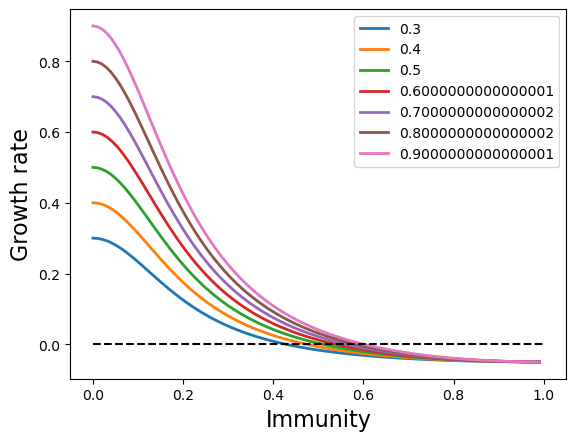

In [181]:
imms = np.arange(0,1,0.01)
rates = np.arange(0.3,0.9,0.1)

ends = np.zeros((len(rates),len(imms)))

for i,rate in enumerate(rates):
    for j,imm in enumerate(imms):
        ends[i,j] = modulate_growth_rate(imm,rate)

fig, ax = plt.subplots()

for i,rate in enumerate(rates):
    ax.plot(imms, ends[i,:], linewidth=2, label = rate)
ax.set_xlabel("Immunity", fontsize=16)
ax.set_ylabel("Growth rate",fontsize=16)
ax.hlines(y=0, xmin = 0, xmax=1,color='k',linestyle='--')
ax.legend()
#fig.savefig("figs/r_immunity.pdf")

In [12]:
growth_rate(0.5,1.4)

0.24885569208795705

In [75]:
growth_rate(0.95,1.3)

0.672818057708006